In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

LOAD DATASET

In [2]:
img_height = 224
img_width = 224
data_directory = "./dataset"
batch_size = 32
train= tf.keras.utils.image_dataset_from_directory(
   data_directory,
   validation_split=0.3,
   subset="training",
   seed=42, 
   image_size=(img_height, img_width),
   batch_size=batch_size,
   labels="inferred",
   label_mode="categorical",
   color_mode="rgb")
test= tf.keras.utils.image_dataset_from_directory(
   data_directory,
   validation_split=0.3,
   subset="validation",
   seed=42, 
   image_size=(img_height, img_width),
   batch_size=batch_size,
   labels="inferred",
   label_mode="categorical",
   color_mode="rgb")


Found 993 files belonging to 9 classes.
Using 696 files for training.
Found 993 files belonging to 9 classes.
Using 297 files for validation.


2023-05-27 18:54:08.984731: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 18:54:09.564344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79135 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


LOAD MODEL

In [3]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet")
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

In [4]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-05-27 18:54:12.925899: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


(32, 7, 7, 1280)


2023-05-27 18:54:14.162586: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-27 18:54:14.163451: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-27 18:54:14.163474: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-27 18:54:14.163993: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-27 18:54:14.164050: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-05-27 18:54:14.176602: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged onc

In [5]:
base_model.trainable = False

In [6]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [7]:
prediction_layer = tf.keras.layers.Dense(9)
activation_pred = tf.keras.layers.Softmax()
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch = activation_pred(prediction_batch)
print(prediction_batch.shape)

(32, 9)


In [8]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer(x)
outputs = activation_pred(x)
model = tf.keras.Model(inputs, outputs)

# COMPILE MODEL & TRAIN

In [9]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 9)                 11529     
                                                                 
 softmax (Softmax)           (None, 9)                 0     

In [11]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(test)

10/10 [==============================] - 2s 27ms/step - loss: 2.9651 - accuracy: 0.1077


In [12]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.97
initial accuracy: 0.11


In [13]:
history = model.fit(train,
                    epochs=initial_epochs,
                    validation_data=test)

Epoch 1/100
22/22 [==============================] - 3s 44ms/step - loss: 2.7801 - accuracy: 0.0776 - val_loss: 2.5103 - val_accuracy: 0.1044
Epoch 2/100
22/22 [==============================] - 1s 39ms/step - loss: 2.5060 - accuracy: 0.1020 - val_loss: 2.3433 - val_accuracy: 0.1111
Epoch 3/100
22/22 [==============================] - 1s 32ms/step - loss: 2.4077 - accuracy: 0.1250 - val_loss: 2.2738 - val_accuracy: 0.1481
Epoch 4/100
22/22 [==============================] - 1s 38ms/step - loss: 2.2987 - accuracy: 0.1422 - val_loss: 2.2283 - val_accuracy: 0.1616
Epoch 5/100
22/22 [==============================] - 1s 35ms/step - loss: 2.2386 - accuracy: 0.1839 - val_loss: 2.1788 - val_accuracy: 0.1818
Epoch 6/100
22/22 [==============================] - 1s 38ms/step - loss: 2.1943 - accuracy: 0.1968 - val_loss: 2.1380 - val_accuracy: 0.2088
Epoch 7/100
22/22 [==============================] - 1s 31ms/step - loss: 2.1528 - accuracy: 0.1868 - val_loss: 2.0988 - val_accuracy: 0.2290
Epoch 

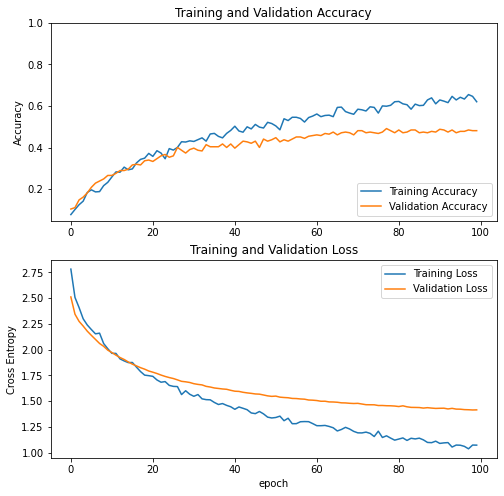

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# FINE TUNING

In [15]:
base_model.trainable = True


In [16]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [18]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 9)                 11529     
                                                                 
 softmax (Softmax)           (None, 9)                 0     

In [19]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test)


Epoch 100/200
22/22 [==============================] - 6s 76ms/step - loss: 0.7005 - accuracy: 0.5934 - val_loss: 0.7089 - val_accuracy: 0.5185
Epoch 101/200
22/22 [==============================] - 1s 38ms/step - loss: 0.6955 - accuracy: 0.6422 - val_loss: 0.7082 - val_accuracy: 0.5118
Epoch 102/200
22/22 [==============================] - 1s 39ms/step - loss: 0.6946 - accuracy: 0.6336 - val_loss: 0.7071 - val_accuracy: 0.4983
Epoch 103/200
22/22 [==============================] - 1s 38ms/step - loss: 0.6909 - accuracy: 0.6868 - val_loss: 0.7080 - val_accuracy: 0.5051
Epoch 104/200
22/22 [==============================] - 1s 40ms/step - loss: 0.6904 - accuracy: 0.6796 - val_loss: 0.7084 - val_accuracy: 0.4848
Epoch 105/200
22/22 [==============================] - 1s 38ms/step - loss: 0.6876 - accuracy: 0.7213 - val_loss: 0.7063 - val_accuracy: 0.4949
Epoch 106/200
22/22 [==============================] - 1s 39ms/step - loss: 0.6876 - accuracy: 0.6954 - val_loss: 0.7070 - val_accuracy:

In [20]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

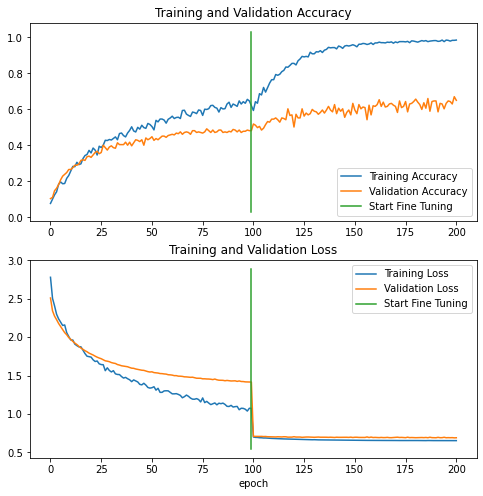

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# EVALUATION

In [22]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

10/10 [==============================] - 0s 15ms/step - loss: 0.6904 - accuracy: 0.6498
Test accuracy : 0.6498316526412964


Predictions:
 [1 1 1 2 1 8 5 8 6 4 7 4 5 1 2 8 7 4 1 8 3 0 7 4 4 1 0 0 6 5 7 2]
Labels:
 [[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 

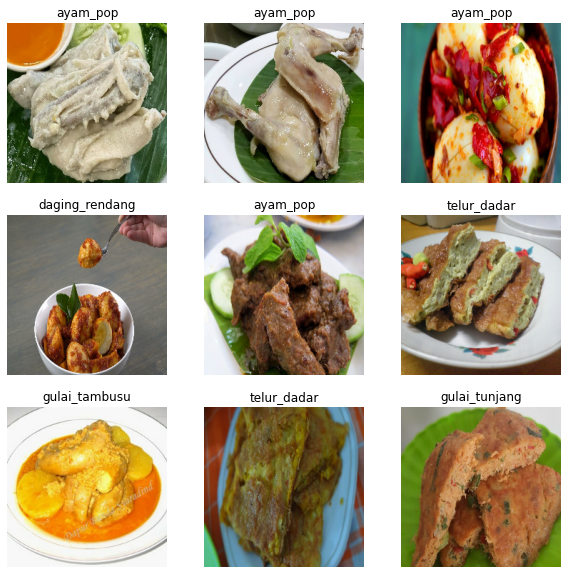

In [23]:
# Retrieve a batch of images from the test set
class_names = train.class_names
image_batch, label_batch = test.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.argmax(predictions, axis=1)


print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [25]:
model.save("./savedModel1.h5")